In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
Trans = lambda x: 10**(-0.2*x/10)
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

In [5]:
def T_avg_one_repeater(L1,L2,Nmax=10000):
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.rand(Nmax),p1)
    N2 = F_geo(np.random.rand(Nmax),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0)
    T_tot = τ1 + np.mean(Ts)
    f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
    f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
    return T_tot, f_memory, f_memory_qkd

def T_avg_mc_n_rep(links, cct= False,Nmax=10000):
    N_links = len(links)
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
    for i in range(1,N_links):
        Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
    
    Ts = np.zeros((N_links-1,Nmax))
    Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    for i in range(1,N_links-1):
        Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
    f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    if cct: # inclduing classical comm. 
        Tsw = np.zeros((N_links-1,Nmax))
        Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
        for i in range(1,N_links-1):
            Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
        T_tot = np.mean(np.max(Tsw,axis=0))           
        Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    else:
        T_tot = np.mean(np.max(Ns,axis=0))
        Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    return T_tot, f_memory, f_memory_qkd


# One repeater

## fixed distance, repeater location sweeping

In [6]:
L0 = 200 # e2e distance [km]
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link = 0.05

δ = 0.3
rep_loc = np.linspace(δ,1-δ,20)
inv_rate_par = np.zeros(len(rep_loc))
f_memory_par = np.zeros(len(rep_loc))
inv_rate_seq = np.zeros(len(rep_loc))
f_memory_seq = np.zeros(len(rep_loc))
for i, pos in enumerate(rep_loc):
    L1 = pos*L0
    L2 = L0 - L1
    inv_rate_par[i], f_memory_par[i], _ = T_avg_one_repeater(L1,L2,Nmax=100000)
    inv_rate_seq[i] = 2*L1/(c*p_link*Trans(L1))+2*L2/(c*p_link*Trans(L2))
        

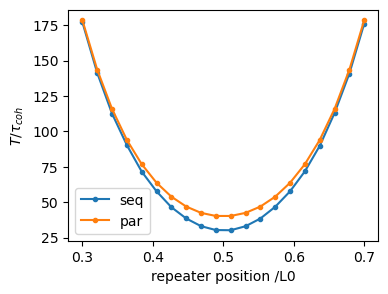

In [7]:
plt.figure(figsize=(4,3))
# plt.plot(rep_loc,inv_rate_par/τ_coh,".-")
plt.plot(rep_loc,inv_rate_par/τ_coh,".-",label="seq")
plt.plot(rep_loc,inv_rate_seq/τ_coh,".-",label="par")
plt.xlabel("repeater position /L0")
plt.ylabel(r"$T/τ_{coh}$")
plt.legend()
plt.show()

# # # plt.subplot(2,1,2)
# plt.figure(figsize=(4,3))
# plt.plot(rep_loc,memory_time_par/τ_coh,".-")
# plt.plot(rep_loc,memory_time_seq/τ_coh,".-")
# plt.xlabel("repeater position /L0")
# plt.ylabel(r"$T_{mem}/τ_{coh}$")
# plt.show()



## rate vs. distance

In [8]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1

L0_list = np.linspace(10,200,101) # e2e distance [km]
inv_rate_par = np.zeros(len(L0_list))
f_memory_par = np.zeros(len(L0_list))
f_memory_qkd_par = np.zeros(len(L0_list))
inv_rate_seq = np.zeros(len(L0_list))
f_memory_seq = np.zeros(len(L0_list))
f_memory_qkd_seq = np.zeros(len(L0_list))
for i, L0 in enumerate(L0_list):
    L1 = L0/2
    L2 = L0/2
    inv_rate_par[i], f_memory_par[i], f_memory_qkd_par[i] = T_avg_one_repeater(L1,L2,Nmax=100000)
    inv_rate_seq[i] = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))
    f_memory_seq[i] = np.exp(-3*L0/c/τ_coh) *p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-4*L2/(c*τ_coh)) )
    f_memory_qkd_seq[i] = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )


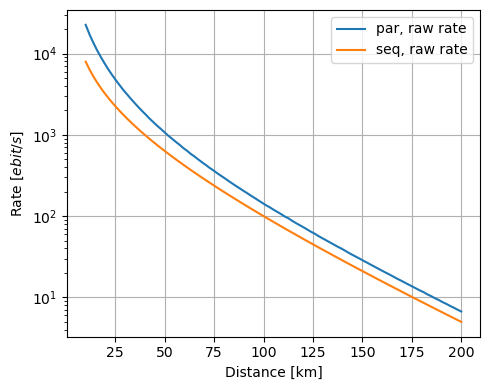

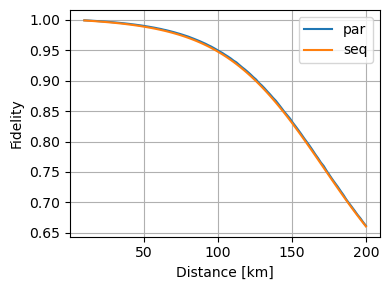

In [9]:
f_qkd_par = 0.5-0.5*f_memory_qkd_par#np.exp(-memory_time_qkd_par/τ_coh)
f_qkd_seq = 0.5-0.5*f_memory_qkd_seq#np.exp(-memory_time_qkd_seq/τ_coh)
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/inv_rate_par,"-",color="C0", label="par, raw rate")
# plt.plot(L0_list,(1-h(f_qkd_par))/inv_rate_par,"--",color="C0", label="par, skr")
plt.plot(L0_list,1/inv_rate_seq,"-",color="C1", label="seq, raw rate")
# plt.plot(L0_list,(1-h(f_qkd_seq))/inv_rate_seq,"--",color="C1", label="seq, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


f_par = 0.5-0.5*f_memory_par#np.exp(-memory_time_par/τ_coh)
f_seq = 0.5-0.5*f_memory_seq#np.exp(-memory_time_seq/τ_coh)
plt.figure(figsize=(4,3))
plt.plot(L0_list,1-f_par,"-", label="par")
plt.plot(L0_list,1-f_seq,"-", label="seq")
# plt.yscale("log")
plt.xlabel("Distance [km]")
# plt.ylabel(r"$T_{mem}/τ_{coh}$")
plt.ylabel("Fidelity")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
plt.show()


## n repeaters

In [18]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1
n = 2 # number of elementary links (i.e., one rep -> n=2)

# L0_list = np.linspace(10,800,101) # e2e distance [km]
L0_list= [247] 
inv_rate_par_2 = np.zeros(len(L0_list))
f_memory_par_2 = np.zeros(len(L0_list))
f_memory_qkd_par_2 = np.zeros(len(L0_list))
inv_rate_seq_2 = np.zeros(len(L0_list))
f_memory_seq_2 = np.zeros(len(L0_list))
f_memory_qkd_seq_2 = np.zeros(len(L0_list))
for i, L0 in enumerate(L0_list):
#     L1 = L0/2
#     L2 = L0/2
    Ls = np.array([L0/n]*n)
#     inv_rate_par[i], memory_time_par[i], memory_time_qkd_par[i] = T_avg_mc(L1,L2,Nmax=100000)
    inv_rate_par_2[i],f_memory_par_2[i],f_memory_qkd_par_2[i] = T_avg_mc_n_rep(Ls,cct=True,Nmax=10000)
    inv_rate_seq_2[i] = np.sum(2*Ls/(c* p_link*Trans(Ls)))
#     memory_time_seq_2[i] = 3*L0/c + 4*np.sum(2*Ls[1:]/(c* p_link*Trans(Ls[1:])))
#     memory_time_qkd_seq[i] = 2*(1/(p_link*Trans(L2))+1)*L2/c
    f_memory_seq_2[i] = np.exp(-3*L0/c/τ_coh) *np.prod(p_link*Trans(Ls[1:])*np.exp(-4*Ls[1:]/(c*τ_coh))/(1- (1-p_link*Trans(Ls[1:]))*np.exp(-4*Ls[1:]/(c*τ_coh)) ) )
    f_memory_qkd_seq_2[i] = np.prod( p_link*Trans(Ls[1:])*np.exp(-4*Ls[1:]/(c*τ_coh))/(1- (1-p_link*Trans(Ls[1:]))*np.exp(-2*Ls[1:]/(c*τ_coh)) )  )


In [16]:
f_qkd_par_2 = 0.5-0.5*f_memory_qkd_par_2#np.exp(-memory_time_qkd_par/τ_coh)
f_qkd_seq_2 = 0.5-0.5*f_memory_qkd_seq_2#np.exp(-memory_time_qkd_seq/τ_coh)
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,p_link*Trans(L0_list)/(2*L0_list/c),"k--", label="DT")
plt.plot(L0_list,1/inv_rate_par_2,"-",color="C0", label="par %d, raw rate" % n)
# plt.plot(L0_list,1/inv_rate_par,"-",color="C1", label="par, raw rate")
plt.plot(L0_list,(1-h(f_qkd_par_2))/inv_rate_par_2,"--",color="C0", label="par %d, skr" % n)
# plt.plot(L0_list,(1-h(f_qkd_par))/inv_rate_par,"--",color="C1", label="par, skr")
plt.plot(L0_list,1/inv_rate_seq_2,"-",color="C1", label="seq %d, raw rate" % n)
plt.plot(L0_list,(1-h(f_qkd_seq_2))/inv_rate_seq_2,"--",color="C1", label="seq %d, skr" % n)
# plt.plot(L0_list,(1-h(f_qkd_seq))/inv_rate_seq,"-.",color="C0", label="seq %d, skr" % n)
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-3,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


# f_par_2 = 0.5-0.5*f_memory_par_2#np.exp(-memory_time_par/τ_coh)
# # f_seq = 0.5-0.5*f_memory_seq#np.exp(-memory_time_seq/τ_coh)
# plt.figure(figsize=(4,3))
# plt.plot(L0_list,1-f_par_2,"-", label="par")
# plt.plot(L0_list,1-f_par,"-", label="par %d" % n)
# # plt.plot(L0_list,1-f_seq,"-", label="seq")
# # plt.yscale("log")
# plt.xlabel("Distance [km]")
# # plt.ylabel(r"$T_{mem}/τ_{coh}$")
# plt.ylabel("Fidelity")
# plt.grid()
# plt.legend()
# plt.tight_layout()
# # plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
# plt.show()


TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 500x400 with 0 Axes>

In [21]:
f_e2e = 0.5+0.5*f_memory_qkd_seq_2
ex = 1- f_e2e
print(ex)

[0.39418755]
